# Libraries

In [2]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from numpy.linalg import norm
from mpl_toolkits.mplot3d import Axes3D 

# Forecasting

### Standard way

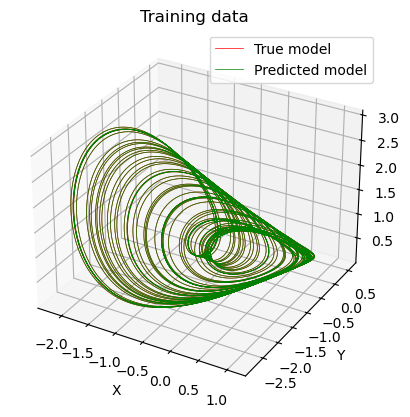

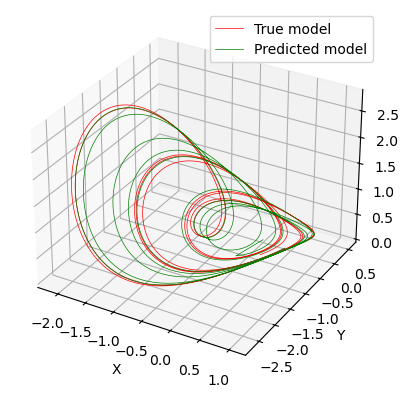

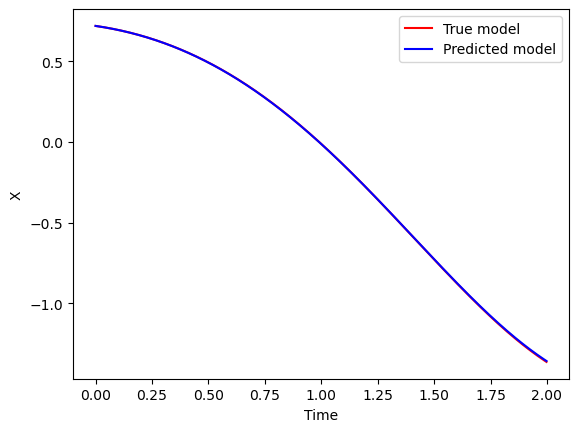

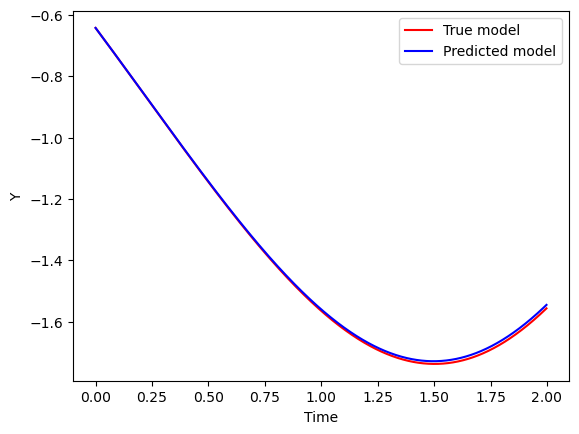

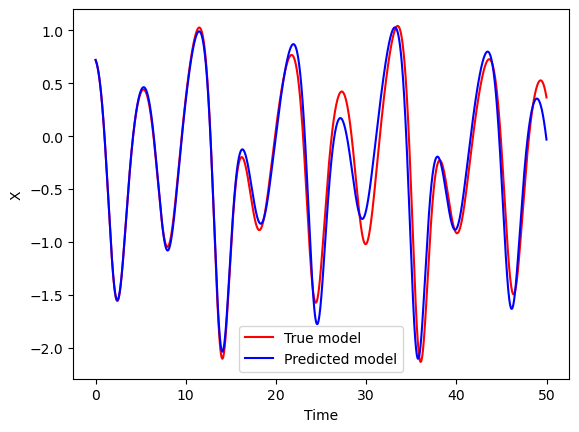

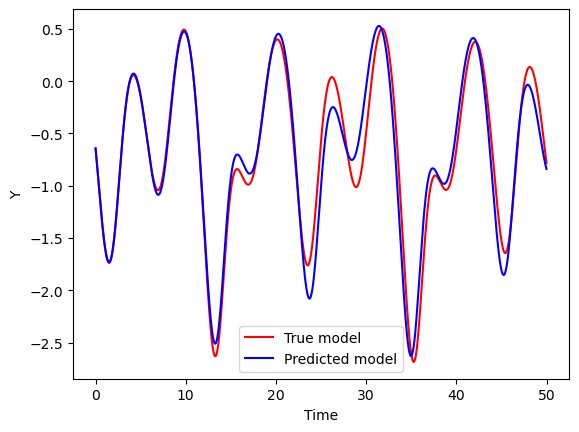

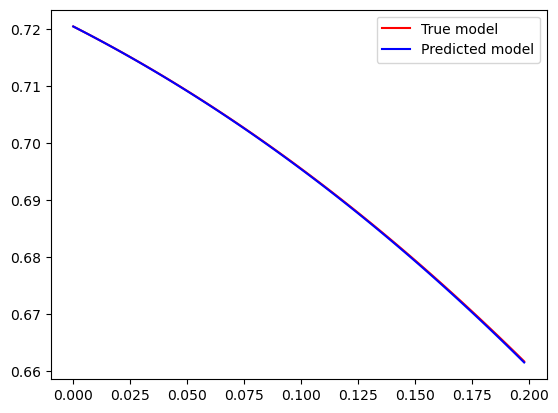

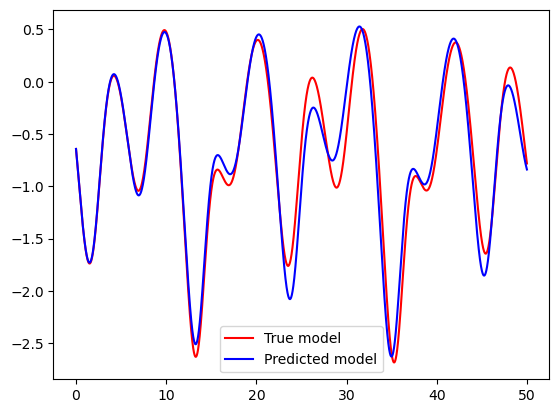

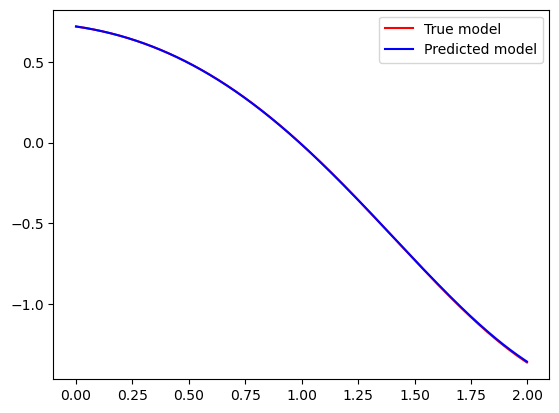

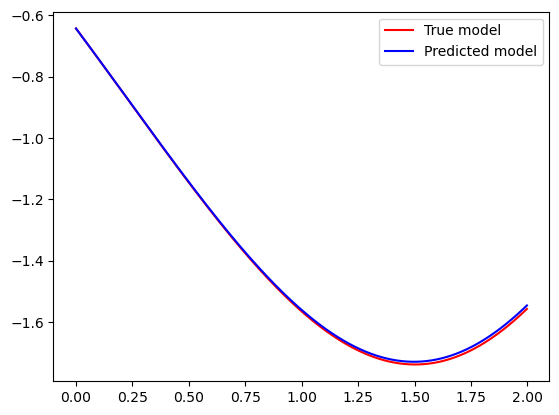

In [4]:
### Initializing parameters for training

## Sprott-Linz system parameters 
a = 0.420

## Reservoir parameters
n = 500                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 1e-4              # Lambda for ridge regression

## Simulation parameters
T = 300
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)

## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
# Win = 0.01 * (2.0 * np.random.rand(n, m) - 1) ######## Ask about scaling - he didn't have 0.01*
Win =  0.1*(2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Sprott-Linz system, time-series data of reservoir states R 
## and time-series data of system states f
x0 = 1.0 * np.random.rand() - 0.5
y0 = 1.0 * np.random.rand() - 0.5
z0 = 1.0 * np.random.rand() - 0.5
x, y, z = x0, y0, z0
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
#rpid0 = 0.5 - 1.0 * np.random.rand(n) ########## Ask about scaling - he has it between -1 to 1, we have it as -0.5 to 0.5
rpid0 = 2*(0.5 - 1.0 * np.random.rand(n))
rpid = rpid0

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = y + z 
    yp = -x + a * y 
    zp = x**2 - z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(A.dot(rpid) + Win.dot(u) + 1)
    #f[:, t] = np.array([x, y, z])
    f[:, t] = u

## Finding Wout matrix using ridge regression

f = f[:, 1000:]
R = R[:, 1000:]

Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

## Checking training data

tempout = Wout_pid.dot(R)
plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(f[0], f[1], f[2], 'r', linewidth = 0.5, label = 'True model')
ax.plot3D(tempout[0], tempout[1], tempout[2], 'g', linewidth = 0.5, label = 'Predicted model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Training data')
plt.show()

## Initializing testing parameters
Ttest = 50
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of predicted system
xtrack = np.zeros(ntest + 1)             
ytrack = np.zeros(ntest + 1)
ztrack = np.zeros(ntest + 1)


xxpure, yypure, zzpure = x, y, z
xxtrack, yytrack, zztrack = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system

    xxpurep = yypure + zzpure
    yypurep = -xxpure + a * yypure
    zzpurep = xxpure**2 - zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   


    ## Forecasting

    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xxtrack, yytrack, zztrack])) + np.ones(n))
    xxtrack, yytrack, zztrack = Wout_pid.dot(rpid)

    xtrack[t] = xxtrack
    ytrack[t] = yytrack
    ztrack[t] = zztrack

 



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.5, label = 'True model')
ax.plot3D(xtrack, ytrack, ztrack, 'g', linewidth = 0.5, label = 'Predicted model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[:1000], xpure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], xtrack[:1000],  'b', label = 'Predicted model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X')
plt.show()


plt.figure()
plt.plot(testingtimes[:1000], ypure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], ytrack[:1000],  'b', label = 'Predicted model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[:ntest], xpure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], xtrack[:ntest],  'b', label = 'Predicted model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X')
plt.show()


plt.figure()
plt.plot(testingtimes[:ntest], ypure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], ytrack[:ntest],  'b', label = 'Predicted model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[:100], xpure[:100], 'r', label = 'True model')
plt.plot(testingtimes[:100], xtrack[:100],  'b', label = 'Predicted model')
plt.legend()
plt.show()

plt.figure()
plt.plot(testingtimes[:ntest], ypure, 'r', label = 'True model')
plt.plot(testingtimes[:ntest], ytrack[:ntest],  'b', label = 'Predicted model')
plt.legend()
plt.show()

plottimerange = np.arange(0, 1000)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xtrack[plottimerange],  'b', label = 'Predicted model')
plt.legend()
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ytrack[plottimerange],  'b', label = 'Predicted model')
plt.legend()
plt.show()




Studying the R matrix:

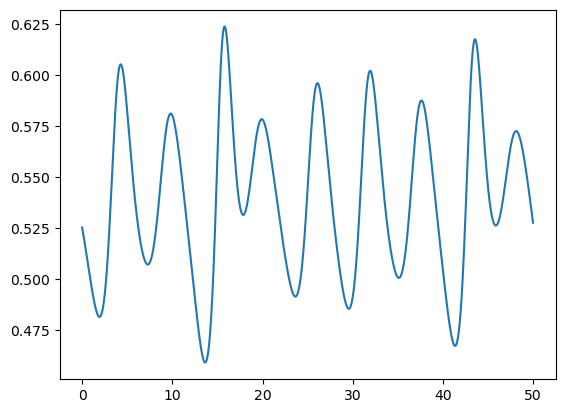

In [7]:
plottimerange = np.arange(0, 25000)
plt.plot(testingtimes[plottimerange], R[np.random.randint(320, n), plottimerange])
plt.show()

### Fixing the bias term:

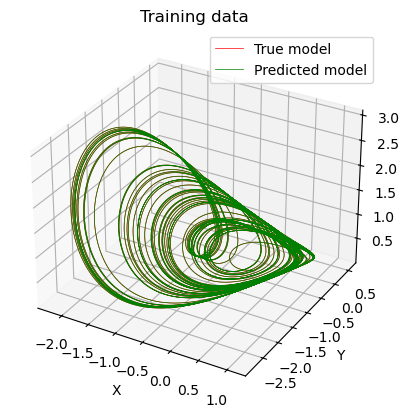

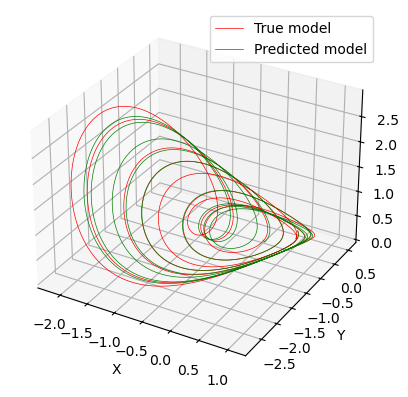

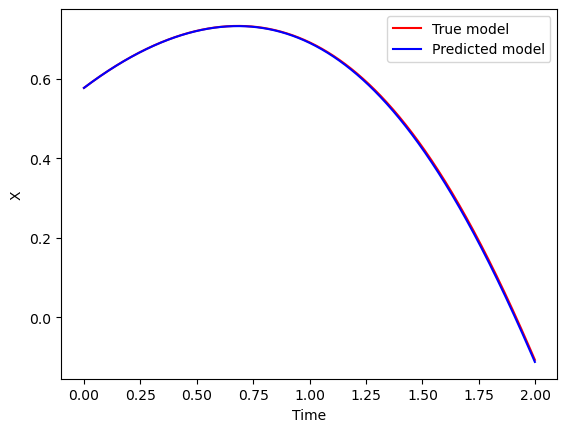

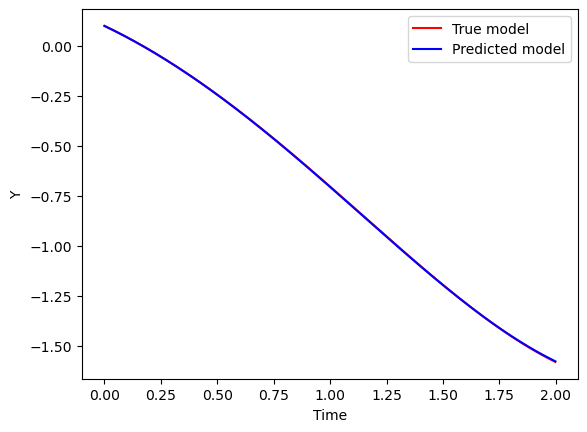

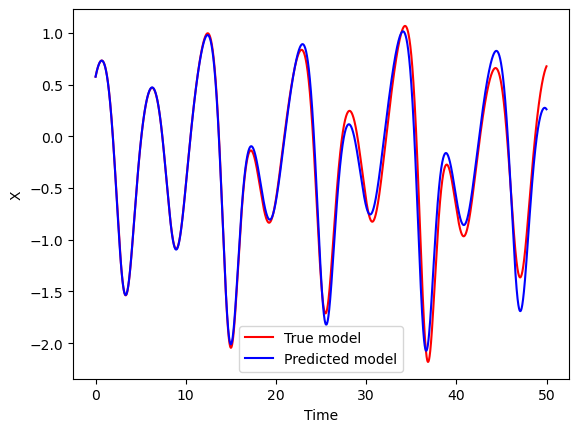

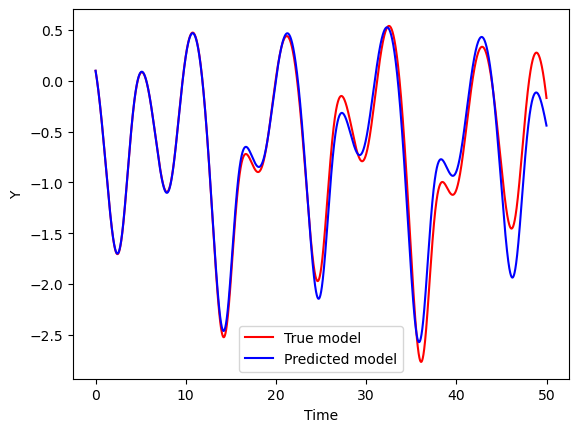

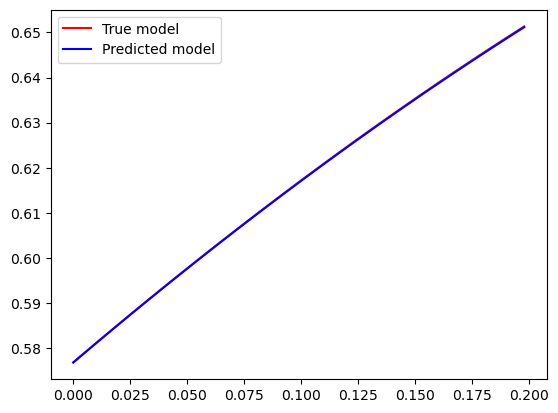

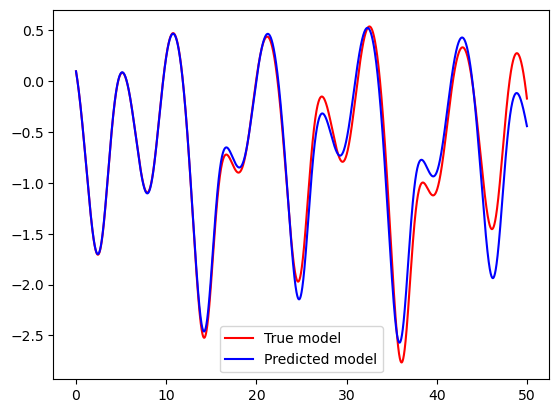

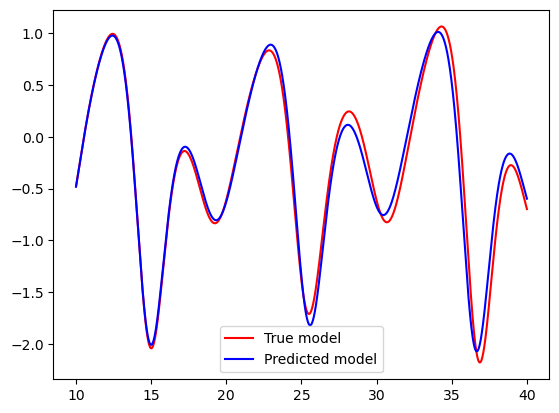

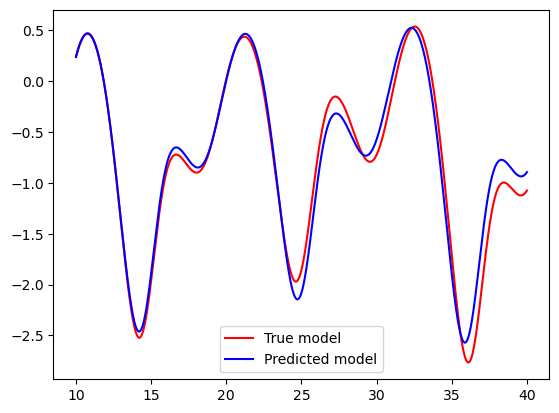

In [11]:
### Initializing parameters for training

## Sprott-Linz system parameters 
a = 0.420

## Reservoir parameters
n = 500                    # reservoir size
m = 3 + 1                       # number of dimensions in the system + 1 for bias 
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 1e-4              # Lambda for ridge regression

## Simulation parameters
T = 300
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)

## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
# Win = 0.01 * (2.0 * np.random.rand(n, m) - 1) ######## Ask about scaling - he didn't have 0.01*
Win =  0.1*(2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Sprott-Linz system, time-series data of reservoir states R 
## and time-series data of system states f
x0 = 1.0 * np.random.rand() - 0.5
y0 = 1.0 * np.random.rand() - 0.5
z0 = 1.0 * np.random.rand() - 0.5
x, y, z = x0, y0, z0
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
#rpid0 = 0.5 - 1.0 * np.random.rand(n) ########## Ask about scaling - he has it between -1 to 1, we have it as -0.5 to 0.5
rpid0 = 2*(0.5 - 1.0 * np.random.rand(n))
rpid = rpid0

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z, 1])
    R[:, t] = rpid
    

    xp = y + z 
    yp = -x + a * y 
    zp = x**2 - z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(A.dot(rpid) + Win.dot(u) + 1)
    #f[:, t] = np.array([x, y, z])
    f[:, t] = u

## Finding Wout matrix using ridge regression

f = f[:, 1000:]
R = R[:, 1000:]

Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

## Checking training data

tempout = Wout_pid.dot(R)
plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(f[0], f[1], f[2], 'r', linewidth = 0.5, label = 'True model')
ax.plot3D(tempout[0], tempout[1], tempout[2], 'g', linewidth = 0.5, label = 'Predicted model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Training data')
plt.show()

## Initializing testing parameters
Ttest = 50
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of predicted system
xtrack = np.zeros(ntest + 1)             
ytrack = np.zeros(ntest + 1)
ztrack = np.zeros(ntest + 1)


xxpure, yypure, zzpure = x, y, z
xxtrack, yytrack, zztrack = x, y, z


## Time evolution
for t in range(ntest):

    ## Ideal system

    xxpurep = yypure + zzpure
    yypurep = -xxpure + a * yypure
    zzpurep = xxpure**2 - zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   


    ## Forecasting


    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xxtrack, yytrack, zztrack, 1])) + np.ones(n))
    xxtrack, yytrack, zztrack, bias = Wout_pid.dot(rpid)

    xtrack[t] = xxtrack
    ytrack[t] = yytrack
    ztrack[t] = zztrack
    
    


 



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.5, label = 'True model')
ax.plot3D(xtrack, ytrack, ztrack, 'g', linewidth = 0.5, label = 'Predicted model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[:1000], xpure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], xtrack[:1000],  'b', label = 'Predicted model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X')
plt.show()


plt.figure()
plt.plot(testingtimes[:1000], ypure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], ytrack[:1000],  'b', label = 'Predicted model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[:ntest], xpure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], xtrack[:ntest],  'b', label = 'Predicted model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X')
plt.show()


plt.figure()
plt.plot(testingtimes[:ntest], ypure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], ytrack[:ntest],  'b', label = 'Predicted model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[:100], xpure[:100], 'r', label = 'True model')
plt.plot(testingtimes[:100], xtrack[:100],  'b', label = 'Predicted model')
plt.legend()
plt.show()

plt.figure()
plt.plot(testingtimes[:ntest], ypure, 'r', label = 'True model')
plt.plot(testingtimes[:ntest], ytrack[:ntest],  'b', label = 'Predicted model')
plt.legend()
plt.show()

plottimerange = np.arange(5000, 20000)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xtrack[plottimerange],  'b', label = 'Predicted model')
plt.legend()
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ytrack[plottimerange],  'b', label = 'Predicted model')
plt.legend()
plt.show()




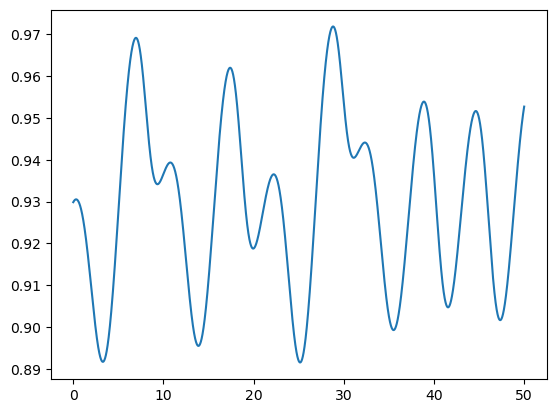

In [118]:
plottimerange = np.arange(0, 25000)
plt.plot(testingtimes[plottimerange], R[np.random.randint(0, n), plottimerange])
plt.show()

Doing the bias this way seems to make it super unstable. Going back to previous way.

### Standard again

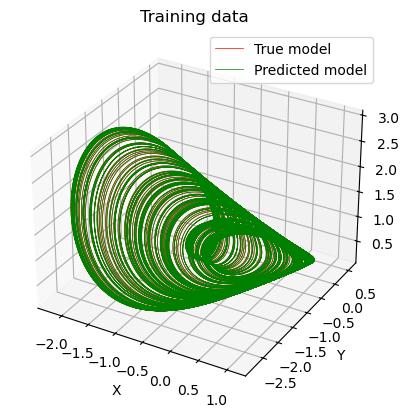

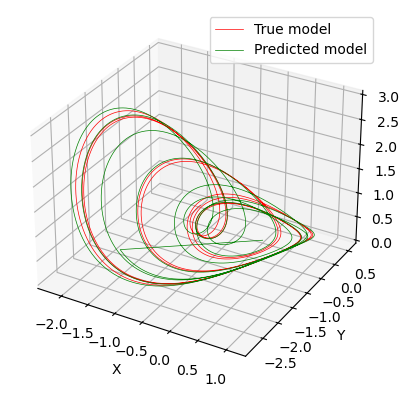

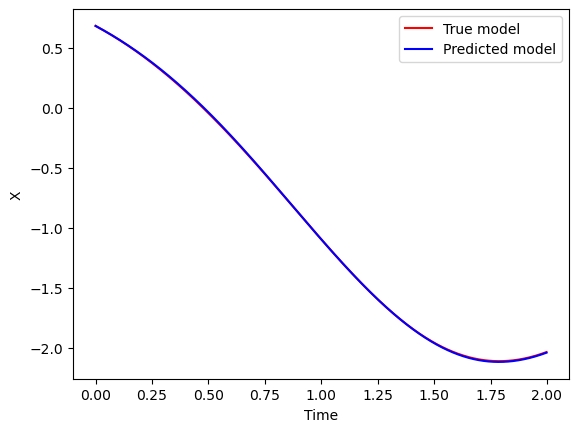

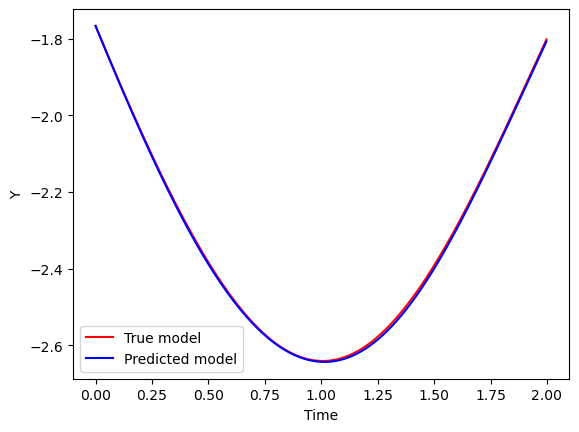

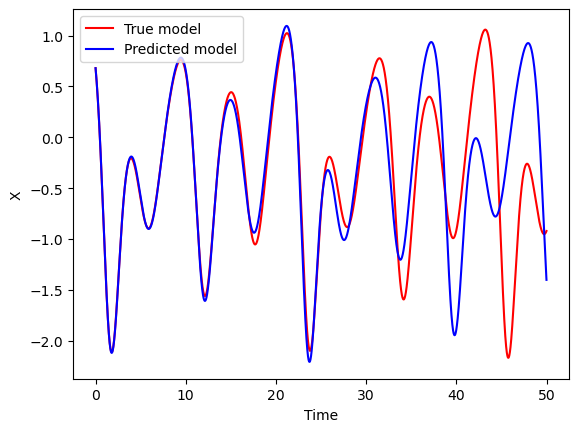

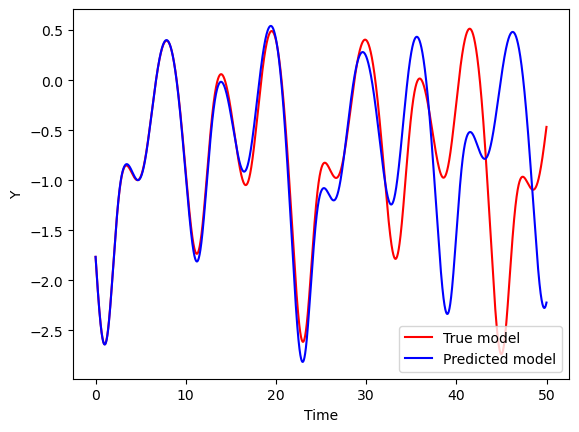

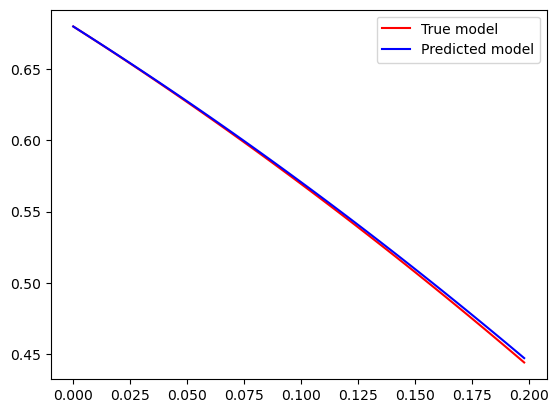

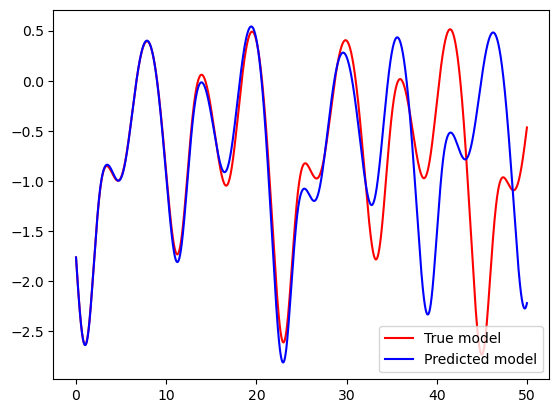

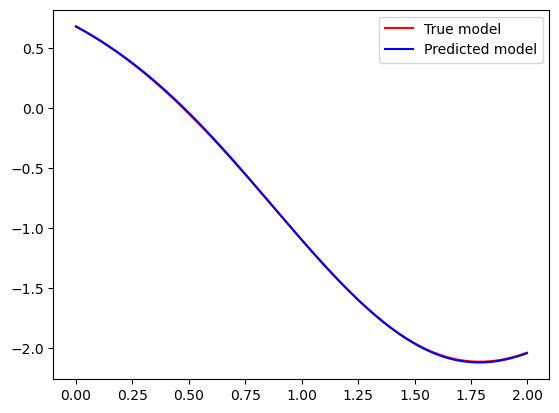

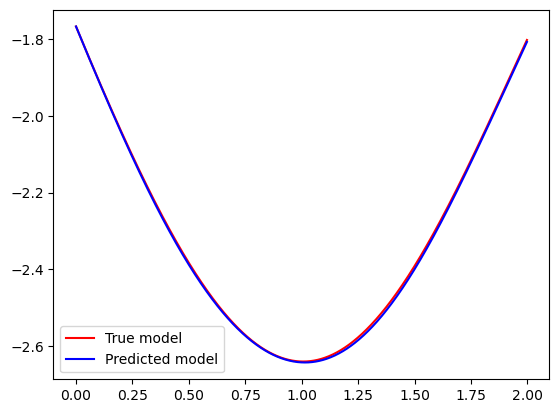

In [3]:
### Initializing parameters for training

## Sprott-Linz system parameters 
a = 0.420

## Reservoir parameters
n = 100                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 1e-4              # Lambda for ridge regression

## Simulation parameters
T = 1000
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)

## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
# Win = 0.01 * (2.0 * np.random.rand(n, m) - 1) ######## Ask about scaling - he didn't have 0.01*
Win =  0.1*(2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Sprott-Linz system, time-series data of reservoir states R 
## and time-series data of system states f
x0 = 1.0 * np.random.rand() - 0.5
y0 = 1.0 * np.random.rand() - 0.5
z0 = 1.0 * np.random.rand() - 0.5
x, y, z = x0, y0, z0
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
#rpid0 = 0.5 - 1.0 * np.random.rand(n) ########## Ask about scaling - he has it between -1 to 1, we have it as -0.5 to 0.5
rpid0 = 2*(0.5 - 1.0 * np.random.rand(n))
rpid = rpid0

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = y + z 
    yp = -x + a * y 
    zp = x**2 - z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(A.dot(rpid) + Win.dot(u) + 1)
    #f[:, t] = np.array([x, y, z])
    f[:, t] = u

## Finding Wout matrix using ridge regression

f = f[:, 1000:]
R = R[:, 1000:]

Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

## Checking training data

tempout = Wout_pid.dot(R)
plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(f[0], f[1], f[2], 'r', linewidth = 0.5, label = 'True model')
ax.plot3D(tempout[0], tempout[1], tempout[2], 'g', linewidth = 0.5, label = 'Predicted model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Training data')
plt.show()

## Initializing testing parameters
Ttest = 50
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of predicted system
xtrack = np.zeros(ntest + 1)             
ytrack = np.zeros(ntest + 1)
ztrack = np.zeros(ntest + 1)


xxpure, yypure, zzpure = x, y, z
xxtrack, yytrack, zztrack = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system

    xxpurep = yypure + zzpure
    yypurep = -xxpure + a * yypure
    zzpurep = xxpure**2 - zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   


    ## Forecasting

    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xxtrack, yytrack, zztrack])) + 1)
    xxtrack, yytrack, zztrack = Wout_pid.dot(rpid)

    xtrack[t] = xxtrack
    ytrack[t] = yytrack
    ztrack[t] = zztrack

 



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.5, label = 'True model')
ax.plot3D(xtrack, ytrack, ztrack, 'g', linewidth = 0.5, label = 'Predicted model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[:1000], xpure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], xtrack[:1000],  'b', label = 'Predicted model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X')
plt.show()


plt.figure()
plt.plot(testingtimes[:1000], ypure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], ytrack[:1000],  'b', label = 'Predicted model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[:ntest], xpure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], xtrack[:ntest],  'b', label = 'Predicted model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X')
plt.show()


plt.figure()
plt.plot(testingtimes[:ntest], ypure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], ytrack[:ntest],  'b', label = 'Predicted model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[:100], xpure[:100], 'r', label = 'True model')
plt.plot(testingtimes[:100], xtrack[:100],  'b', label = 'Predicted model')
plt.legend()
plt.show()

plt.figure()
plt.plot(testingtimes[:ntest], ypure, 'r', label = 'True model')
plt.plot(testingtimes[:ntest], ytrack[:ntest],  'b', label = 'Predicted model')
plt.legend()
plt.show()

plottimerange = np.arange(0, 1000)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xtrack[plottimerange],  'b', label = 'Predicted model')
plt.legend()
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ytrack[plottimerange],  'b', label = 'Predicted model')
plt.legend()
plt.show()




### Trying different activation functions:

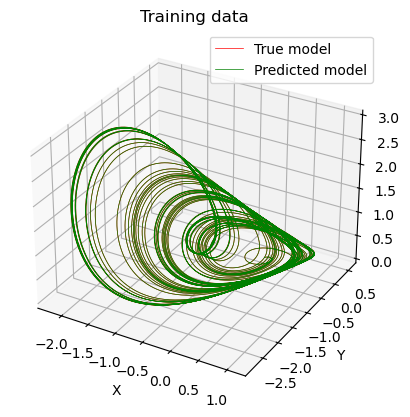

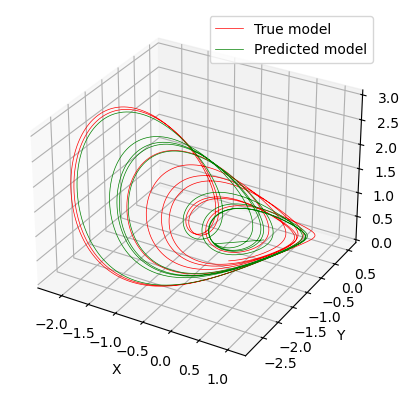

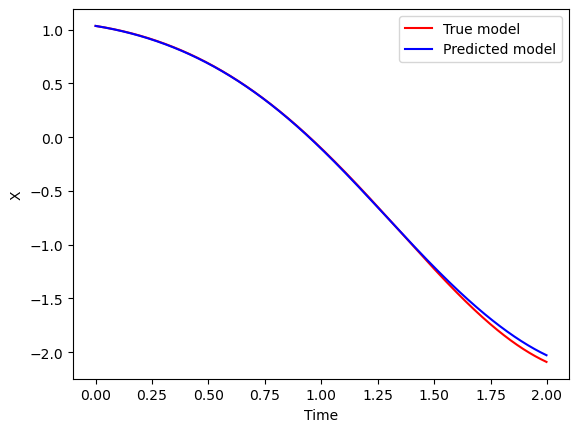

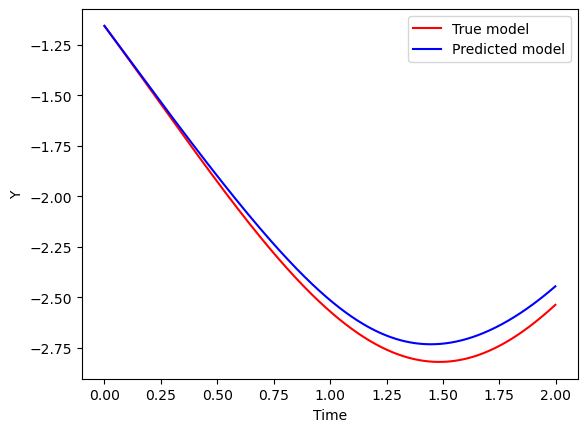

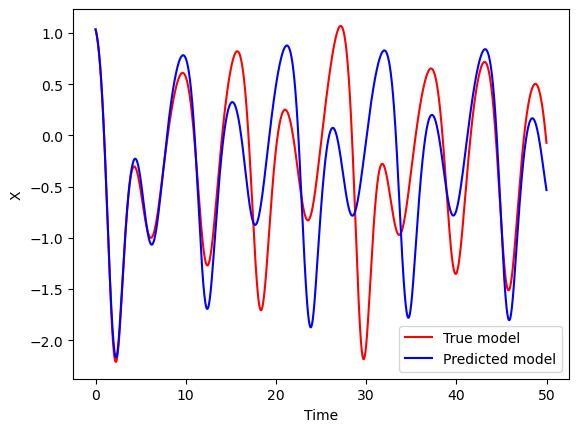

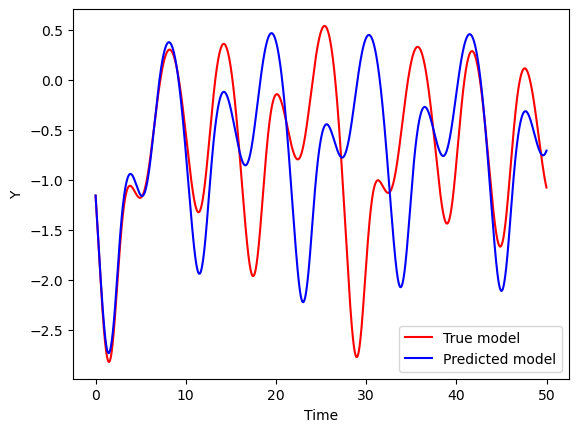

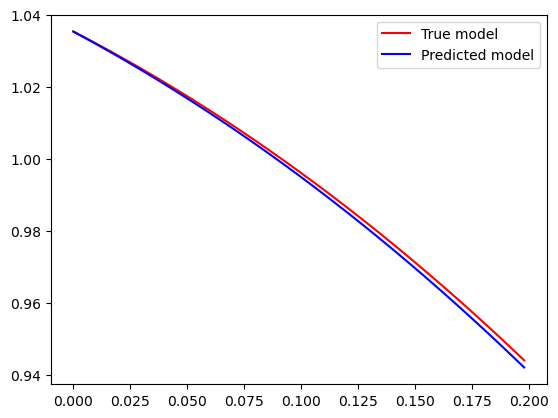

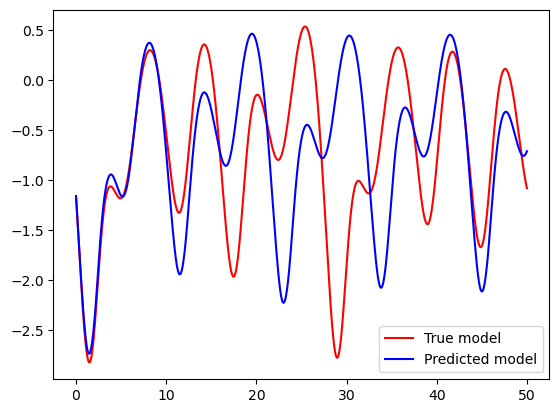

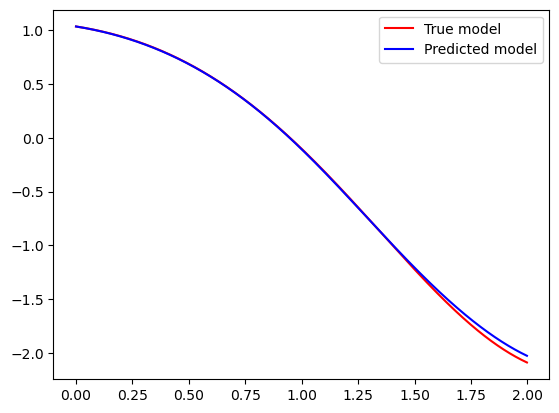

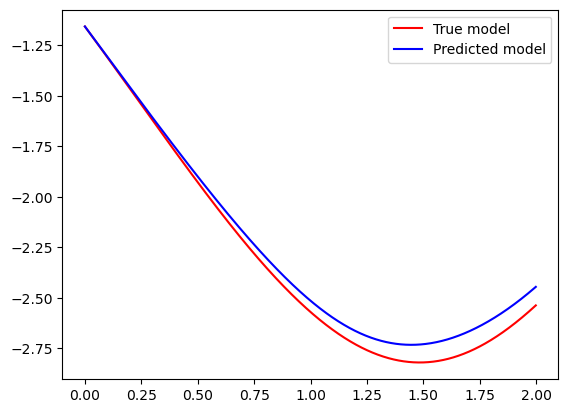

In [126]:
def sigmoid(x):
    # Clip values to avoid overflow in exp
    x_clipped = np.clip(x, -500, 500)
    return np.where(
        x_clipped >= 0,
        1 / (1 + np.exp(-x_clipped)),
        np.exp(x_clipped) / (1 + np.exp(x_clipped))
    )

### Initializing parameters for training

## Sprott-Linz system parameters 
a = 0.420

## Reservoir parameters
n = 500                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 1e-4              # Lambda for ridge regression

## Simulation parameters
T = 300
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)

## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
# Win = 0.01 * (2.0 * np.random.rand(n, m) - 1) ######## Ask about scaling - he didn't have 0.01*
Win =  0.1*(2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Sprott-Linz system, time-series data of reservoir states R 
## and time-series data of system states f
x0 = 1.0 * np.random.rand() - 0.5
y0 = 1.0 * np.random.rand() - 0.5
z0 = 1.0 * np.random.rand() - 0.5
x, y, z = x0, y0, z0
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
#rpid0 = 0.5 - 1.0 * np.random.rand(n) ########## Ask about scaling - he has it between -1 to 1, we have it as -0.5 to 0.5
rpid0 = 2*(0.5 - 1.0 * np.random.rand(n))
rpid = rpid0

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = y + z 
    yp = -x + a * y 
    zp = x**2 - z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = sigmoid(A.dot(rpid) + Win.dot(u)) #np.tanh(A.dot(rpid) + Win.dot(u) + 1)
    #f[:, t] = np.array([x, y, z])
    f[:, t] = u

## Finding Wout matrix using ridge regression

f = f[:, 1000:]
R = R[:, 1000:]

Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

## Checking training data

tempout = Wout_pid.dot(R)
plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(f[0], f[1], f[2], 'r', linewidth = 0.5, label = 'True model')
ax.plot3D(tempout[0], tempout[1], tempout[2], 'g', linewidth = 0.5, label = 'Predicted model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Training data')
plt.show()

## Initializing testing parameters
Ttest = 50
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of predicted system
xtrack = np.zeros(ntest + 1)             
ytrack = np.zeros(ntest + 1)
ztrack = np.zeros(ntest + 1)


xxpure, yypure, zzpure = x, y, z
xxtrack, yytrack, zztrack = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system

    xxpurep = yypure + zzpure
    yypurep = -xxpure + a * yypure
    zzpurep = xxpure**2 - zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   


    ## Forecasting

    rpid = sigmoid(A.dot(rpid) + Win.dot(np.array([xxtrack, yytrack, zztrack]))) #np.tanh(A.dot(rpid) + Win.dot(np.array([xxtrack, yytrack, zztrack])) + 1)
    xxtrack, yytrack, zztrack = Wout_pid.dot(rpid)

    xtrack[t] = xxtrack
    ytrack[t] = yytrack
    ztrack[t] = zztrack

 



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.5, label = 'True model')
ax.plot3D(xtrack, ytrack, ztrack, 'g', linewidth = 0.5, label = 'Predicted model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[:1000], xpure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], xtrack[:1000],  'b', label = 'Predicted model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X')
plt.show()


plt.figure()
plt.plot(testingtimes[:1000], ypure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], ytrack[:1000],  'b', label = 'Predicted model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[:ntest], xpure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], xtrack[:ntest],  'b', label = 'Predicted model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X')
plt.show()


plt.figure()
plt.plot(testingtimes[:ntest], ypure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], ytrack[:ntest],  'b', label = 'Predicted model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[:100], xpure[:100], 'r', label = 'True model')
plt.plot(testingtimes[:100], xtrack[:100],  'b', label = 'Predicted model')
plt.legend()
plt.show()

plt.figure()
plt.plot(testingtimes[:ntest], ypure, 'r', label = 'True model')
plt.plot(testingtimes[:ntest], ytrack[:ntest],  'b', label = 'Predicted model')
plt.legend()
plt.show()

plottimerange = np.arange(0, 1000)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xtrack[plottimerange],  'b', label = 'Predicted model')
plt.legend()
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ytrack[plottimerange],  'b', label = 'Predicted model')
plt.legend()
plt.show()




### Try normalizing after linear layer (layer normalization)

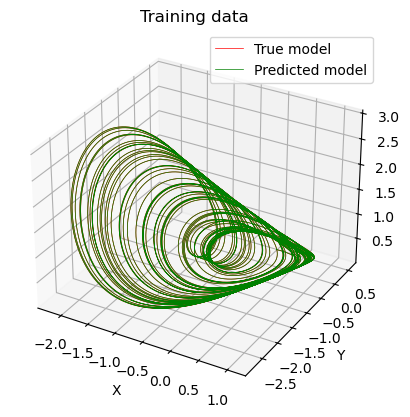

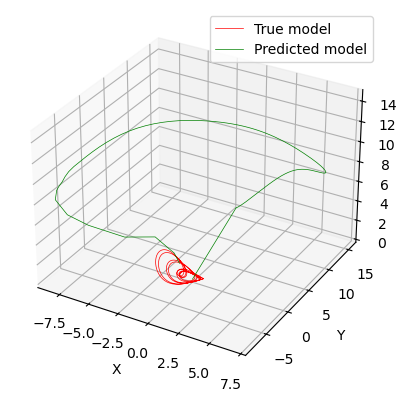

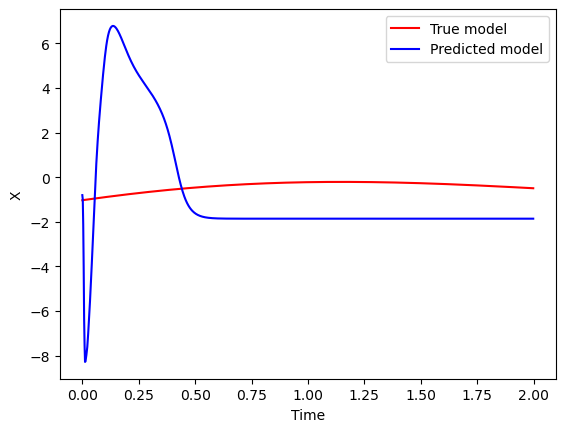

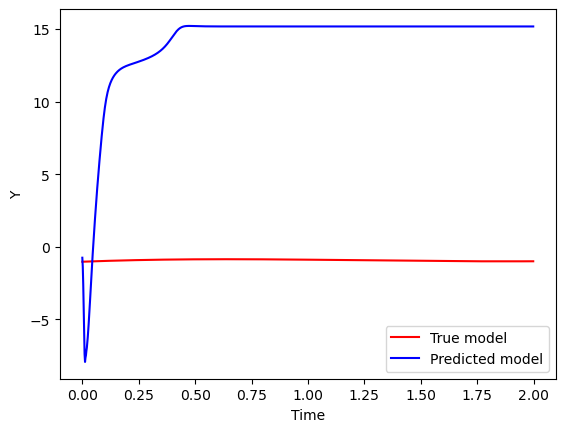

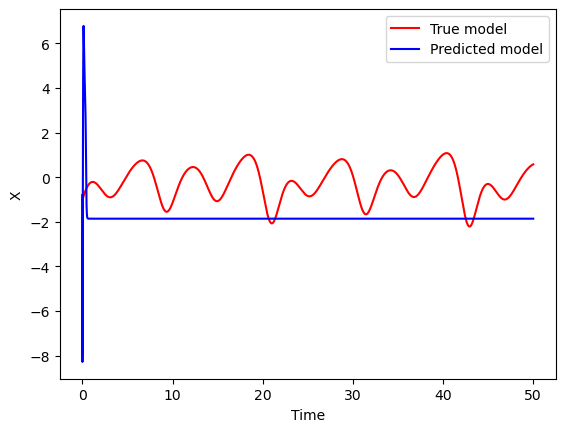

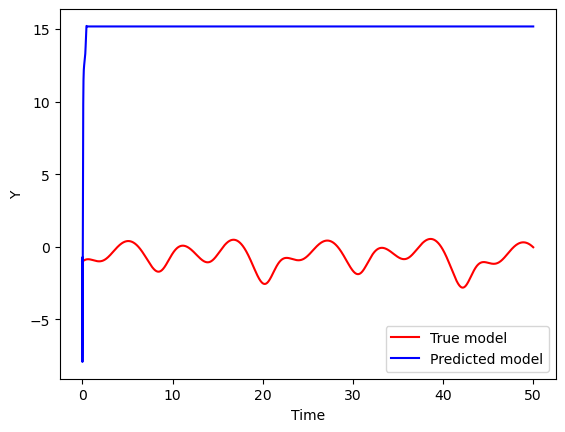

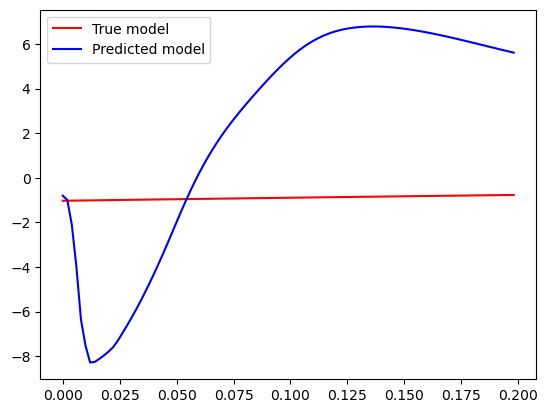

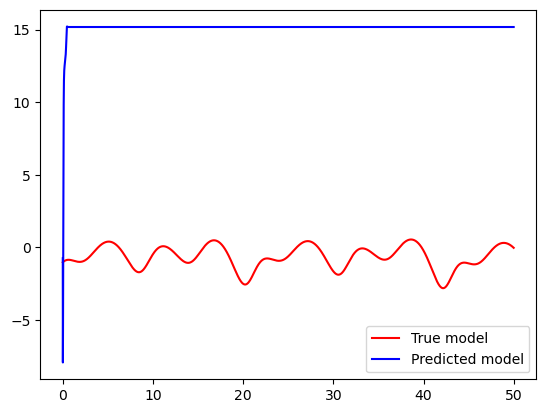

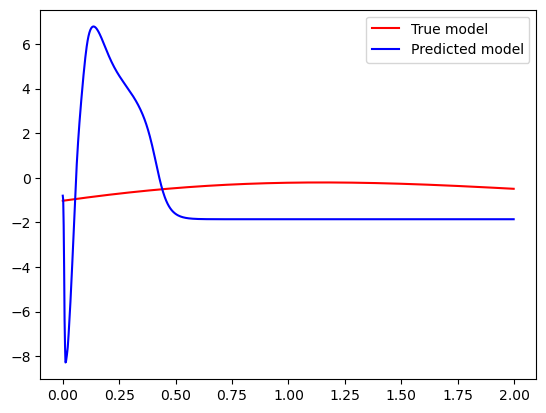

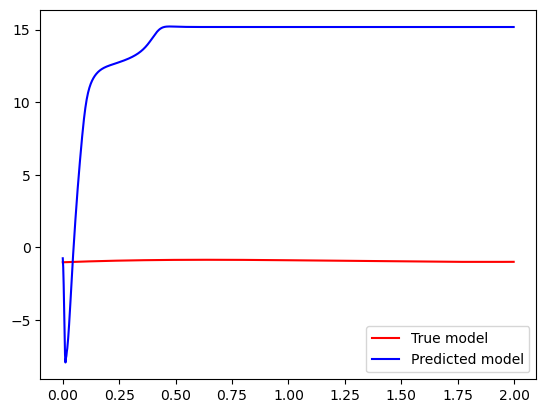

In [8]:
### Initializing parameters for training

## Sprott-Linz system parameters 
a = 0.420

## Reservoir parameters
n = 500                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 1e-4              # Lambda for ridge regression

## Simulation parameters
T = 300
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)

## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
# Win = 0.01 * (2.0 * np.random.rand(n, m) - 1) ######## Ask about scaling - he didn't have 0.01*
Win =  0.1*(2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Sprott-Linz system, time-series data of reservoir states R 
## and time-series data of system states f
x0 = 1.0 * np.random.rand() - 0.5
y0 = 1.0 * np.random.rand() - 0.5
z0 = 1.0 * np.random.rand() - 0.5
x, y, z = x0, y0, z0
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
#rpid0 = 0.5 - 1.0 * np.random.rand(n) ########## Ask about scaling - he has it between -1 to 1, we have it as -0.5 to 0.5
rpid0 = 2*(0.5 - 1.0 * np.random.rand(n))
rpid = rpid0

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = y + z 
    yp = -x + a * y 
    zp = x**2 - z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(A.dot(rpid) + Win.dot(u) + 1)
    #f[:, t] = np.array([x, y, z])
    f[:, t] = u

## Finding Wout matrix using ridge regression

f = f[:, 1000:]
R = R[:, 1000:]

Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

## Checking training data

tempout = Wout_pid.dot(R)
plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(f[0], f[1], f[2], 'r', linewidth = 0.5, label = 'True model')
ax.plot3D(tempout[0], tempout[1], tempout[2], 'g', linewidth = 0.5, label = 'Predicted model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Training data')
plt.show()

## Initializing testing parameters
Ttest = 50
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of predicted system
xtrack = np.zeros(ntest + 1)             
ytrack = np.zeros(ntest + 1)
ztrack = np.zeros(ntest + 1)


xxpure, yypure, zzpure = x, y, z
xxtrack, yytrack, zztrack = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system

    xxpurep = yypure + zzpure
    yypurep = -xxpure + a * yypure
    zzpurep = xxpure**2 - zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   


    ## Forecasting

    h = A.dot(rpid) + Win.dot(np.array([xxtrack, yytrack, zztrack])) + 1
    h = (h - np.mean(h)) / np.std(h)                          
    rpid = np.tanh(h)
    xxtrack, yytrack, zztrack = Wout_pid.dot(rpid)

    xtrack[t] = xxtrack
    ytrack[t] = yytrack
    ztrack[t] = zztrack

 



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.5, label = 'True model')
ax.plot3D(xtrack, ytrack, ztrack, 'g', linewidth = 0.5, label = 'Predicted model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[:1000], xpure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], xtrack[:1000],  'b', label = 'Predicted model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X')
plt.show()


plt.figure()
plt.plot(testingtimes[:1000], ypure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], ytrack[:1000],  'b', label = 'Predicted model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[:ntest], xpure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], xtrack[:ntest],  'b', label = 'Predicted model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X')
plt.show()


plt.figure()
plt.plot(testingtimes[:ntest], ypure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], ytrack[:ntest],  'b', label = 'Predicted model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[:100], xpure[:100], 'r', label = 'True model')
plt.plot(testingtimes[:100], xtrack[:100],  'b', label = 'Predicted model')
plt.legend()
plt.show()

plt.figure()
plt.plot(testingtimes[:ntest], ypure, 'r', label = 'True model')
plt.plot(testingtimes[:ntest], ytrack[:ntest],  'b', label = 'Predicted model')
plt.legend()
plt.show()

plottimerange = np.arange(0, 1000)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xtrack[plottimerange],  'b', label = 'Predicted model')
plt.legend()
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ytrack[plottimerange],  'b', label = 'Predicted model')
plt.legend()
plt.show()




Clearly not working

### Standardize input first before going into reservoir

In [ ]:
### Initializing parameters for training

## Sprott-Linz system parameters 
a = 0.420

## Reservoir parameters
n = 500                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 1e-4              # Lambda for ridge regression

## Simulation parameters
T = 300
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)

## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
# Win = 0.01 * (2.0 * np.random.rand(n, m) - 1) ######## Ask about scaling - he didn't have 0.01*
Win =  0.1*(2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Sprott-Linz system, time-series data of reservoir states R 
## and time-series data of system states f
x0 = 1.0 * np.random.rand() - 0.5
y0 = 1.0 * np.random.rand() - 0.5
z0 = 1.0 * np.random.rand() - 0.5
x, y, z = x0, y0, z0
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
#rpid0 = 0.5 - 1.0 * np.random.rand(n) ########## Ask about scaling - he has it between -1 to 1, we have it as -0.5 to 0.5
rpid0 = 2*(0.5 - 1.0 * np.random.rand(n))
rpid = rpid0

## Collecting reservoir time-series data

for t in range(ntraining):

    u = np.array([x, y, z])

    xp = y + z 
    yp = -x + a * y 
    zp = x**2 - z

    x += dt * xp
    y += dt * yp
    z += dt * zp

   
    f[:, t] = u

trainingmean = f.mean(axis = 1, keepdims = True)
trainingstd = f.std(axis = 1, keepdims = True)
f = (f - trainingmean) / trainingstd

for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid


    rpid = np.tanh(A.dot(rpid) + Win.dot(f[:, t]) + 1)
    #f[:, t] = np.array([x, y, z])


## Finding Wout matrix using ridge regression

f = f[:, 1000:]
R = R[:, 1000:]

Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

## Checking training data

tempout = Wout_pid.dot(R)
plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(f[0], f[1], f[2], 'r', linewidth = 0.5, label = 'True model')
ax.plot3D(tempout[0], tempout[1], tempout[2], 'g', linewidth = 0.5, label = 'Predicted model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Training data')
plt.show()

## Initializing testing parameters
Ttest = 50
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of predicted system
xtrack = np.zeros(ntest + 1)             
ytrack = np.zeros(ntest + 1)
ztrack = np.zeros(ntest + 1)


xxpure, yypure, zzpure = x, y, z
xxtrack, yytrack, zztrack = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system

    xxpurep = yypure + zzpure
    yypurep = -xxpure + a * yypure
    zzpurep = xxpure**2 - zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   


    ## Forecasting

    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xxtrack, yytrack, zztrack])) + np.ones(n))
    xxtrack, yytrack, zztrack = Wout_pid.dot(rpid)

    xtrack[t] = xxtrack
    ytrack[t] = yytrack
    ztrack[t] = zztrack

 



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.5, label = 'True model')
ax.plot3D(xtrack, ytrack, ztrack, 'g', linewidth = 0.5, label = 'Predicted model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[:1000], xpure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], xtrack[:1000],  'b', label = 'Predicted model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X')
plt.show()


plt.figure()
plt.plot(testingtimes[:1000], ypure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], ytrack[:1000],  'b', label = 'Predicted model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[:ntest], xpure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], xtrack[:ntest],  'b', label = 'Predicted model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X')
plt.show()


plt.figure()
plt.plot(testingtimes[:ntest], ypure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], ytrack[:ntest],  'b', label = 'Predicted model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[:100], xpure[:100], 'r', label = 'True model')
plt.plot(testingtimes[:100], xtrack[:100],  'b', label = 'Predicted model')
plt.legend()
plt.show()

plt.figure()
plt.plot(testingtimes[:ntest], ypure, 'r', label = 'True model')
plt.plot(testingtimes[:ntest], ytrack[:ntest],  'b', label = 'Predicted model')
plt.legend()
plt.show()

plottimerange = np.arange(0, 1000)

plt.figure()
plt.plot(testingtimes[plottimerange], xpure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xtrack[plottimerange],  'b', label = 'Predicted model')
plt.legend()
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], ypure[plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ytrack[plottimerange],  'b', label = 'Predicted model')
plt.legend()
plt.show()




# Feedback control

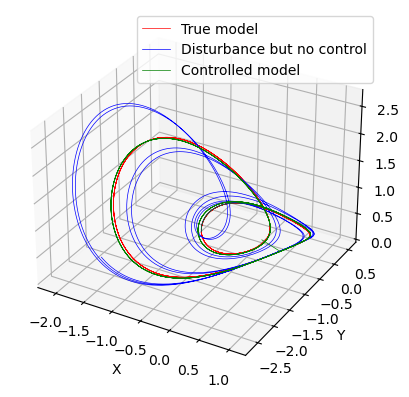

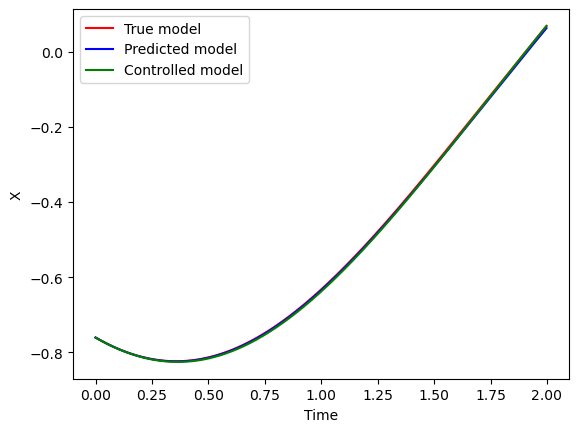

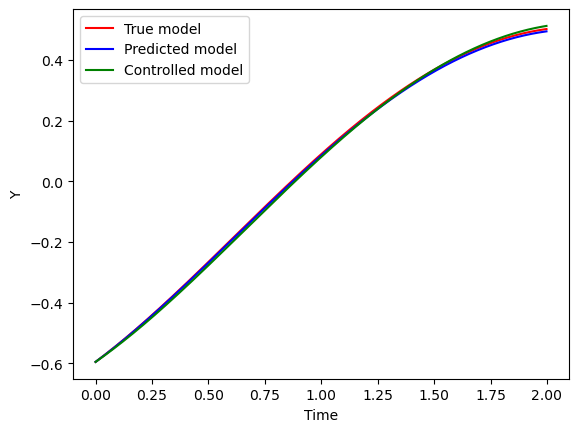

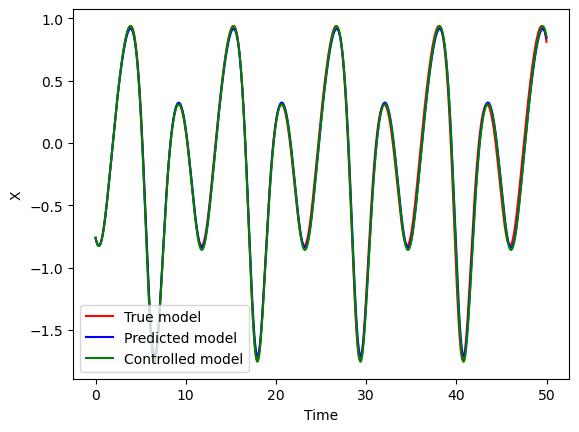

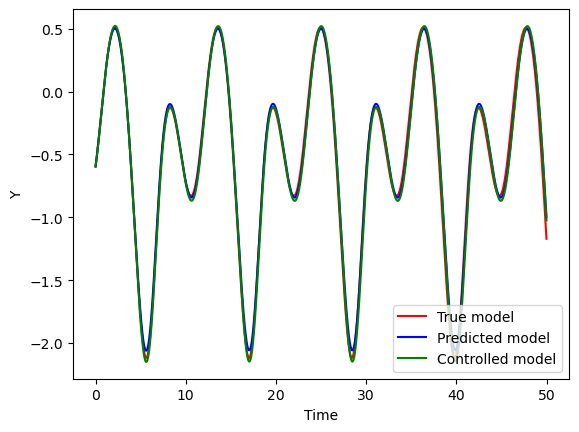

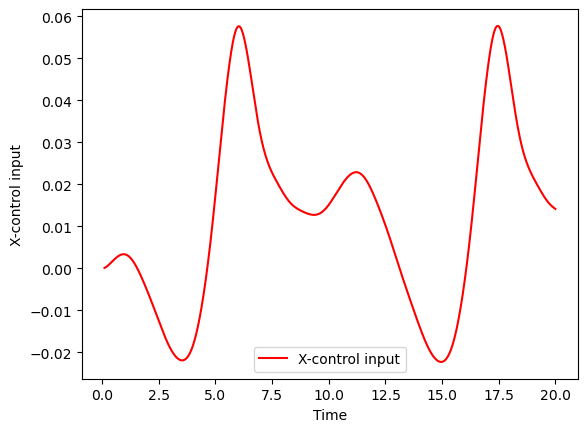

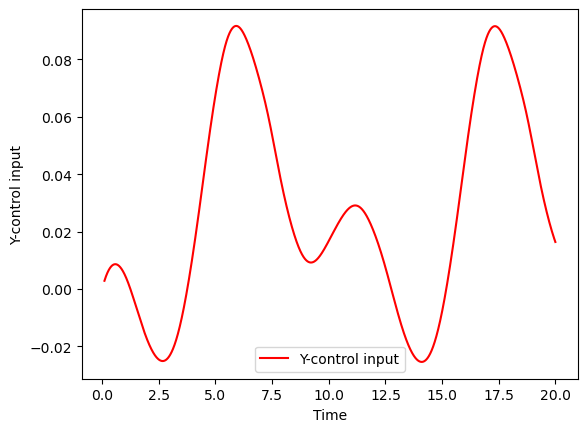

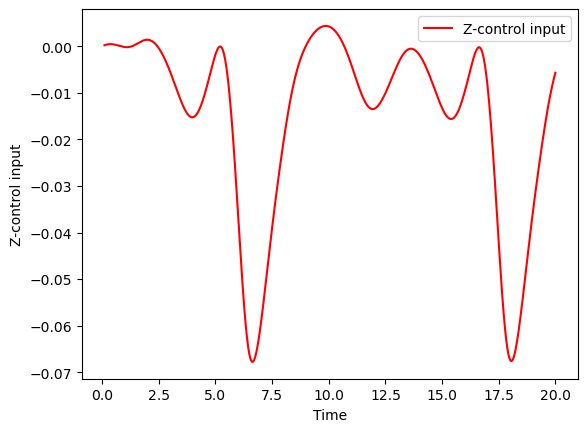

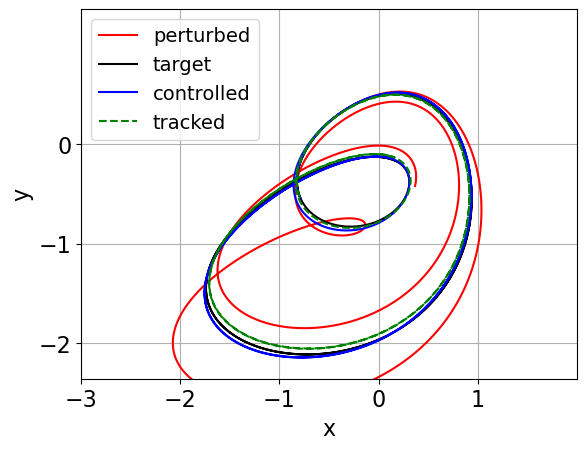

Total energy =  0.0028080895440447417


In [54]:
### Initializing parameters for training

## Sprott-Linz system parameters 
a = 0.340

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 1e-4              # Lambda for ridge regression

## Simulation parameters
T = 300
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)

## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.1 * (2.0 * np.random.rand(n, m) - 1) ######## Ask about scaling - he didn't have 0.01*


### Training reservoir to model the system

## Inital state of Sprott-Linz system, time-series data of reservoir states R 
## and time-series data of system states f
x = 1.0 * np.random.rand() - 0.5
y = 1.0 * np.random.rand() - 0.5
z = 1.0 * np.random.rand() - 0.5
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 2*(0.5 - 1.0 * np.random.rand(n)) ########## Ask about scaling - he has it between -1 to 1, we have it as -0.5 to 0.5

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = y + z 
    yp = -x + a * y 
    zp = x**2 - z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(A.dot(rpid) + Win.dot(u) + 1)
    #f[:, t] = np.array([x, y, z])
    f[:, t] = u

## Finding Wout matrix using ridge regression
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

## Initializing testing parameters
Ttest = 50
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)
disb = 0.4022 - 0.340
controlgain = 1

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of system with disturbance with no control
xnocontrol = np.zeros(ntest)
ynocontrol = np.zeros(ntest)
znocontrol = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest + 1)             
ypid = np.zeros(ntest + 1)
zpid = np.zeros(ntest + 1)

## For storing x, y, z time series data of predicted system
xtrack = np.zeros(ntest + 1)             
ytrack = np.zeros(ntest + 1)
ztrack = np.zeros(ntest + 1)

## For storing control inputs
controlx = np.zeros(ntest + 1)
controly = np.zeros(ntest + 1)
controlz = np.zeros(ntest + 1)

xxpure, yypure, zzpure = x, y, z
xxnocontrol, yynocontrol, zznocontrol = x, y, z
xxpid, yypid, zzpid = x, y, z
xpid[0], ypid[0], zpid[0] = x, y, z
xxtrack, yytrack, zztrack = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system

    xxpurep = yypure + zzpure
    yypurep = -xxpure + a * yypure
    zzpurep = xxpure**2 - zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## With disturbance (Real trajectory with no control)

    xxnocontrolp = yynocontrol + zznocontrol
    yynocontrolp = -xxnocontrol + (a + disb) * yynocontrol
    zznocontrolp = xxnocontrol**2 - zznocontrol
    
    xxnocontrol += dt * xxnocontrolp
    yynocontrol += dt * yynocontrolp
    zznocontrol += dt * zznocontrolp

    xnocontrol[t] = xxnocontrol
    ynocontrol[t] = yynocontrol
    znocontrol[t] = zznocontrol

    ## Actual system with PID control
   
    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xxtrack, yytrack, zztrack])) + np.ones(n))
    xxtrack, yytrack, zztrack = Wout_pid.dot(rpid)

    xtrack[t] = xxtrack
    ytrack[t] = yytrack
    ztrack[t] = zztrack

    xxpidp = yypid + zzpid
    yypidp = -xxpid + (a + disb) * yypid
    zzpidp = xxpid**2 - zzpid
    
    xxpid += dt * (xxpidp + controlgain * (xxtrack - xxpid))
    yypid += dt * (yypidp + controlgain * (yytrack - yypid))
    zzpid += dt * (zzpidp + controlgain * (zztrack - zzpid))
    

    xpid[t] = xxpid
    ypid[t] = yypid
    zpid[t] = zzpid

    controlx[t] =  (xxtrack - xxpid)
    controly[t] =  (yytrack - yypid)
    controlz[t] =  (zztrack - zzpid)





plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.5, label = 'True model')
ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.5, label = 'Disturbance but no control')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.5, label = 'Controlled model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Finding distance between tracked and true model at each time instant and averaging it
#avgtimedist = np.mean(np.sqrt((xpure - xpid[:ntest])**2 + (ypure - ypid[:ntest])**2 + (zpure - zpid[:ntest])**2))

#print('Average of distances calculated at each instant:', avgtimedist)


## Finding distance between tracked and true model by finding the minimum distance between the two time series
#A = np.array([xpure[-5000:], ypure[-5000:], zpure[-5000:]])
#B = np.array([xpid[-5000:], ypid[-5000:], zpid[-5000:]])
#avgdist = np.mean(norm(A[:, :, None] - B[:, None, :], axis=0).min(axis=0))
#print('Average of minimum distances:', avgdist)

plt.figure()
plt.plot(testingtimes[:1000], xpure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], xtrack[:1000],  'b', label = 'Predicted model')
plt.plot(testingtimes[:1000], xpid[:1000],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X')
plt.show()


plt.figure()
plt.plot(testingtimes[:1000], ypure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], ytrack[:1000],  'b', label = 'Predicted model')
plt.plot(testingtimes[:1000], ypid[:1000],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

plt.figure()
plt.plot(testingtimes[:ntest], xpure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], xtrack[:ntest],  'b', label = 'Predicted model')
plt.plot(testingtimes[:ntest], xpid[:ntest],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X')
plt.show()


plt.figure()
plt.plot(testingtimes[:ntest], ypure[:ntest], 'r', label = 'True model')
plt.plot(testingtimes[:ntest], ytrack[:ntest],  'b', label = 'Predicted model')
plt.plot(testingtimes[:ntest], ypid[:ntest],  'g', label = 'Controlled model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y')
plt.show()

# plottimerange = np.arange(0, 1000)



# plt.figure()
# plt.plot(testingtimes[:100], xpure[:100], 'r', label = 'True model')
# plt.plot(testingtimes[:100], xtrack[:100],  'b', label = 'Predicted model')
# plt.legend()
# plt.show()

# plt.figure()
# plt.plot(testingtimes[:ntest], ypure, 'r', label = 'True model')
# plt.plot(testingtimes[:ntest], ytrack[:ntest],  'b', label = 'Predicted model')
# plt.legend()
# plt.show()




# plt.figure()
# plt.plot(testingtimes[100:200], ypure[100:200], 'r', label = 'True model')
# plt.plot(testingtimes[100:200], ynocontrol[100:200],  'g', label = 'Disturbed model')
# plt.legend()
# plt.show()

plottimerange = np.arange(50, 10000)

plt.figure()
plt.plot(testingtimes[plottimerange], controlgain * controlx[plottimerange], 'r', label = 'X-control input')
plt.legend()
plt.xlabel('Time')
plt.ylabel('X-control input')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], controlgain * controly[plottimerange], 'r', label = 'Y-control input')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Y-control input')
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], controlgain * controlz[plottimerange], 'r', label = 'Z-control input')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Z-control input')
plt.show()

plt.figure()
plt.plot(xnocontrol[plottimerange], ynocontrol[plottimerange], 'r-', linewidth=1.5, label='perturbed')
plt.plot(xpure[plottimerange], ypure[plottimerange], 'k-', linewidth=1.5, label='target')
plt.plot(xpid[plottimerange], ypid[plottimerange], 'b-', linewidth=1.5, label='controlled')
plt.plot(xtrack[plottimerange], ytrack[plottimerange], 'g--', linewidth=1.5, label='tracked')

plt.grid(True)
# plt.box(True) # Box on by default
plt.axis('equal') # Make aspect ratio equal
plt.xlim([-3, 2])
plt.ylim([-3, 2])
plt.legend(fontsize=14, loc='upper left') # Equivalent to NorthWest
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xticks([-3, -2, -1, 0, 1])
plt.yticks([-3, -2, -1, 0])
plt.show()

print("Total energy = ", 
      np.sum(dt * controlgain ** 2 * np.sum(controlx ** 2 + controly ** 2 + controlz ** 2))/(Ttest))

